In [62]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import json


dataframes = ["TheftEvent.parquet"]
attach_config_vars = ["generation_empty_w"]

folder = Path(".").resolve() / "data" / "experiments"
regex = r"(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})_(.+)_(\d{5})"


def load_experiments_by_name(name) -> dict[str, pd.DataFrame]:

    dfs = {dfname: [] for dfname in dataframes}

    for ent in folder.iterdir():

        if not ent.is_dir():
            continue

        res = re.match(regex, ent.name)
        
        if res is None:
            continue

        dstr, namestr, randstr = res.group(1), res.group(2), res.group(3)

        if namestr != name:
            continue

        with open(ent / "config.json", "r", encoding="utf-8") as f:
            config = json.load(f)
        
        
        for dfname in dataframes:
            df = pd.read_parquet(ent / dfname) 
            df["rand"]= randstr
            
            for av in attach_config_vars:
                df[av] = config[av]
            
            dfs[dfname].append(df)

    
    dfs = {dfname: pd.concat(inners, ignore_index=True) for dfname, inners in dfs.items()}

    return dfs
        
df = load_experiments_by_name("empty_1-50_20_10")["TheftEvent.parquet"]

ValueError: No objects to concatenate

In [32]:
df.head(3)

,caught,thieve_i,target_i,vision,cos_angle,t,rand,generation_empty_w
0,False,202,132,0.00,-0.861109,136,13216,5.0
1,False,210,8,0.00,-0.692066,680,13216,5.0
2,True,201,184,0.85,-0.999872,1088,13216,5.0


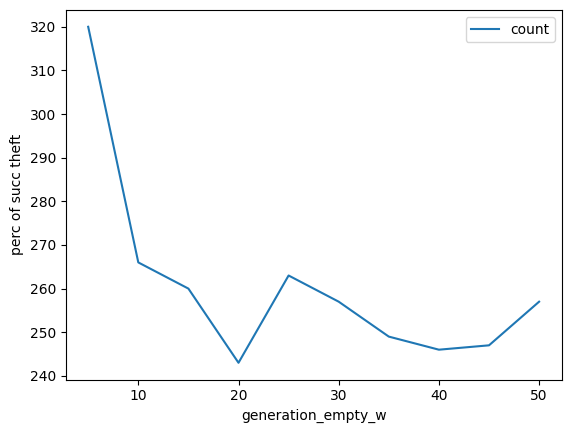

In [46]:
from matplotlib import pyplot as plt

cr = df.groupby("generation_empty_w")["caught"].value_counts()
cr = cr.reset_index()
ts = cr[cr["caught"] == False]
ax = ts.plot.line("generation_empty_w", "count")
ax.set_ylabel("perc of succ theft")
plt.show()

Text(0, 0.5, 'N of thefts')

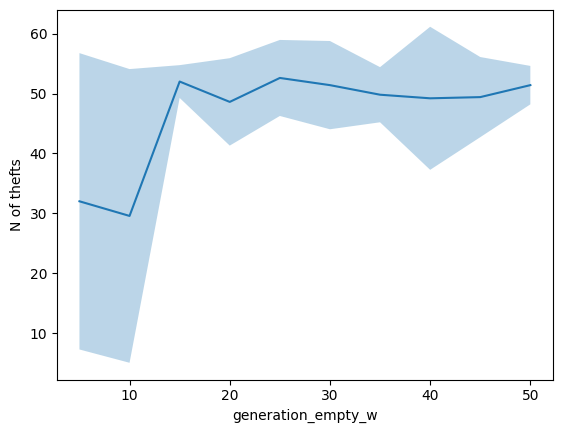

In [60]:
g = df.groupby(["rand", "generation_empty_w"])["caught"].value_counts()
g = g.reset_index()
g = g[~g["caught"]]

interest = "generation_empty_w"
def process(df: pd.DataFrame):
    return pd.DataFrame({"stole_mean": [df["count"].mean()], "stole_std": [df["count"].std()]})

g = g.groupby("generation_empty_w").apply(process)
g = g.reset_index().drop(columns="level_1")


fig, ax = plt.subplots()
ax.plot(g[interest], g["stole_mean"])
upper = g["stole_mean"] + g["stole_std"]
lower = g["stole_mean"] - g["stole_std"]

ax.fill_between(g[interest], upper, lower, alpha=0.3)
ax.set_xlabel(interest)
ax.set_ylabel("N of thefts")